In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as linalg
import numpy.random as random
import scipy.stats as stats
import scipy.integrate as integrate

In [3]:
mu = np.array([4, 2])
cov = np.array([[1.44, -0.702],[-0.702, 0.81]])
precision = linalg.inv(cov)

joint_mvn = stats.multivariate_normal(mu, cov)

In [4]:
#marginalizing over X1 and X2
marginalized_1 = stats.norm(mu[0], cov[0, 0])
marginalized_2 = stats.norm(mu[1], cov[1, 1])

In [5]:
#conditioning
x2_given = 1
conditioned_1 = stats.norm(mu[0] - (1/precision[0, 0])*precision[0, 1]*(x2_given - mu[1]), 1/precision[0, 0])

x1_given = 3
conditioned_2 = stats.norm(mu[1] - (1/precision[1, 1])*precision[1, 0]*(x1_given - mu[0]), 1/precision[1, 1])

In [6]:
def credibility_intervals(xmax, cov, dx=0.01, xrange=5):
    N = int(xrange/dx)
    i = 0
    while i < N:
        integ, err = integrate.quad(stats.norm.pdf, xmax-i*dx, xmax+i*dx, args=(xmax, cov))
        if integ>=0.95:
            break
        i += 1
    return i*dx, integ

def gaussian(x, mu, cov):
    inv_cov = linalg.inv(cov)
    return np.exp(-0.5*((x - mu)**2)/cov**2)

In [7]:
#estimating the credibility intervals
credibility_marginalized_1 = credibility_intervals(mu[0], cov[0, 0])
credibility_marginalized_2 = credibility_intervals(mu[1], cov[1, 1])

mu_given_x2 = mu[0] - (1/precision[0, 0])*precision[0, 1]*(x2_given - mu[1])
credibility_conditioned_1 = credibility_intervals(mu_given_x2, 1/precision[0, 0])
mu_given_x1 = mu[1] - (1/precision[1, 1])*precision[1, 0]*(x1_given - mu[0])
credibility_conditioned_2 = credibility_intervals(mu_given_x1, 1/precision[1, 1])

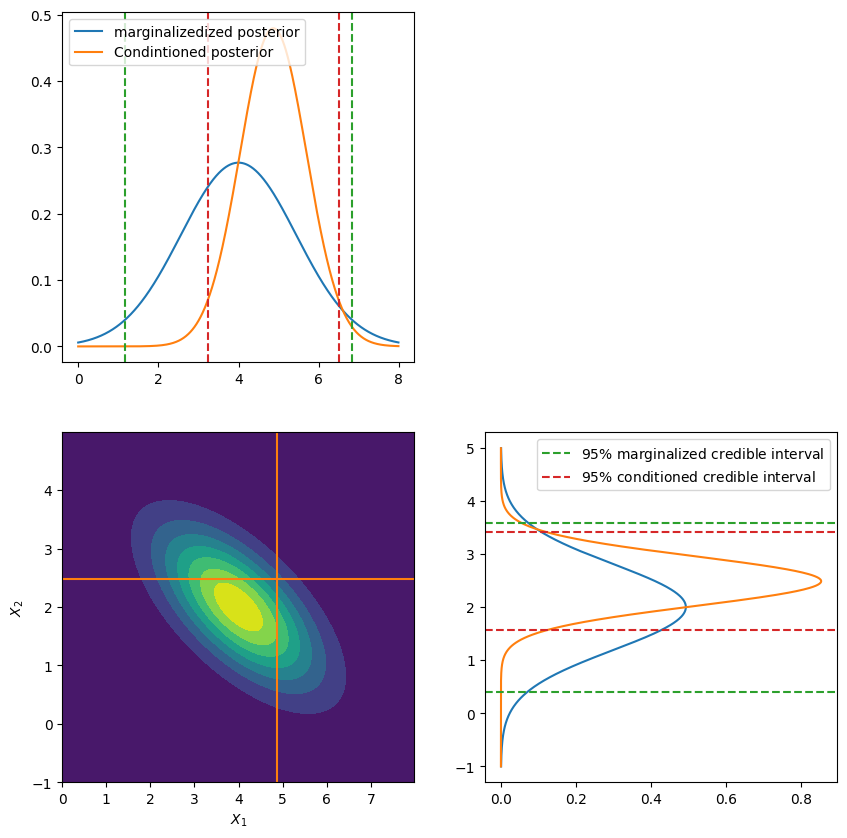

In [8]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(223)
x1, x2 = np.mgrid[0:8:.01, -1:5:.01]
X = np.dstack((x1, x2))
Z = joint_mvn.pdf(X)
contour = ax.contourf(x1, x2, Z, cmap = 'viridis')

ax.axvline(mu_given_x2, c='C1')
ax.axhline(mu_given_x1, c='C1')
ax.set_xlabel('$X_1$')
ax.set_ylabel('$X_2$')

ax = fig.add_subplot(221)
ax.plot(x1[:, 0], marginalized_1.pdf(x1[:, 0]), label='marginalizedized posterior')
ax.plot(x1[:, 0], conditioned_1.pdf(x1[:, 0]), label='Condintioned posterior')
ax.axvline(mu[0]-credibility_marginalized_1[0], ls='--', c='C2')
ax.axvline(mu[0]+credibility_marginalized_1[0], ls='--', c='C2')
ax.axvline(mu_given_x2-credibility_conditioned_1[0], ls='--', c='C3')
ax.axvline(mu_given_x2+credibility_conditioned_1[0], ls='--', c='C3')
ax.legend(loc='best')

ax = fig.add_subplot(224)
ax.plot(marginalized_2.pdf(x2[0, :]), x2[0, :])
ax.plot(conditioned_2.pdf(x2[0, :]), x2[0, :])
ax.axhline(mu[1]-credibility_marginalized_2[0], ls='--', c='C2', label='$95 \\%$ marginalized credible interval')
ax.axhline(mu[1]+credibility_marginalized_2[0], ls='--', c='C2')
ax.axhline(mu_given_x1-credibility_conditioned_2[0], ls='--', c='C3', label='$95 \\%$ conditioned credible interval')
ax.axhline(mu_given_x1+credibility_conditioned_2[0], ls='--', c='C3')
ax.legend(loc='best')

plt.show()

As it can be seen from the plot above, the conditioned posterior is narrower than the marginalized one. Moreover, they are centered in different values with respect to the "true" ones. This affects the 95% credible boundaries which are shifted, but still smaller or equal than the marginalized ones. This is because when you condition over parameters you do not have error propagation effects.

### Cholesky decomposition

In [9]:
def Cholesky_decomposition(mu, cov, nsample):
    L = linalg.cholesky(cov)
    chain = np.zeros([nsample, 2])

    for j in range(nsample):

        v = np.zeros(2)
        for i in range(2):
            v[i] = random.normal(0, 1)

        sample = mu + np.dot(L, v)
        chain[j, :] = sample

    return chain

def histogram_2D(chain, dx=0.1):
    x1max = np.amax(chain[:, 0])
    x1min = np.amin(chain[:, 0])
    x2max = np.amax(chain[:, 1])
    x2min = np.amin(chain[:, 1])
    n1 = int((x1max - x1min)/dx) + 1
    n2 = int((x2max - x2min)/dx) + 1

    hist_2D = np.zeros((n1, n2))
    X1 = np.linspace(x1min, x1max, n1)
    X2 = np.linspace(x2min, x2max, n2)

    max_p = 0
    xmax = np.zeros(2)
    
    for i in range(len(chain)):
        index1 = int((chain[i, 0] - x1min)/dx)
        index2 = int((chain[i, 1] - x2min)/dx)
        hist_2D[index1][index2] += 1/(len(chain)*dx**2)
        if (hist_2D[index1][index2] > max_p):
            max_p = hist_2D[index1][index2]
            xmax[0] = index1
            xmax[1] = index2
    
    xmax[0] = xmax[0]*dx + x1min
    xmax[1] = xmax[1]*dx + x2min

    return X1, X2, hist_2D, xmax

Nbins = 100

def hist_max(counts):
    xmax = np.amax(counts)

    for i in range(len(counts)):
        if counts[i] == xmax:
            return i

def credible_intervals_hist(counts, bins):
    imax = hist_max(counts)

    total = sum(counts)

    fractional = 0
    i = 1

    while fractional < 0.95:

        counting = sum(counts[(imax - i):(imax + i)])
        fractional = counting/total
        i += 1

    return i, imax


In [10]:
ch_sample = Cholesky_decomposition(mu, cov, 10000)
X1_ch, X2_ch, histo2D_ch, xmax_ch = histogram_2D(ch_sample)

counts1_ch, bins1_ch = np.histogram(ch_sample[:, 0], Nbins, density='True')
i1, imax1 = credible_intervals_hist(counts1_ch, bins1_ch)

counts2_ch, bins2_ch = np.histogram(ch_sample[:, 1], Nbins, density='True')
i2, imax2 = credible_intervals_hist(counts2_ch, bins2_ch)

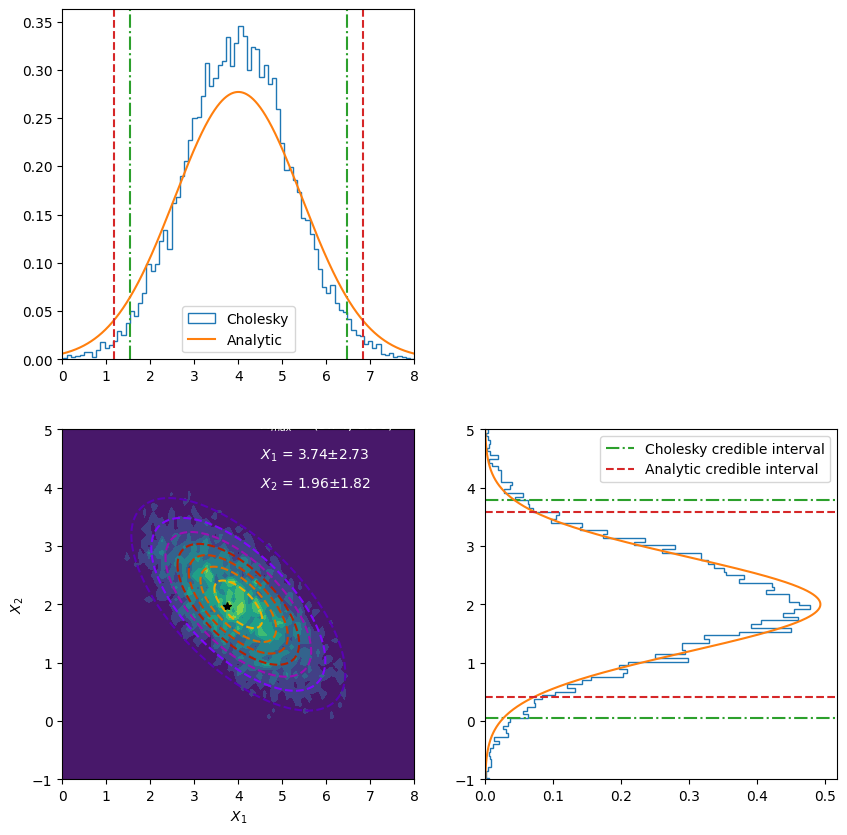

In [11]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(223)

ax.contour(x1, x2, Z, linestyles='dashed', cmap='gnuplot')
ax.contourf(X1_ch, X2_ch, histo2D_ch.T)
ax.plot(xmax_ch[0], xmax_ch[1], 'k*')
ax.text(4.5, 5, s='$X_{max}$ = ('+str(f'{xmax_ch[0]:.2f}')+', '+str(f'{xmax_ch[1]:.2f}')+')', c='white')
ax.text(4.5, 4.5, s='$X_{1}$ = '+str(f'{xmax_ch[0]:.2f}')+'$ \\pm $'+str(f'{bins1_ch[imax1+i1]-xmax_ch[0]:.2f}'), c='white')
ax.text(4.5, 4, s='$X_{2}$ = '+str(f'{xmax_ch[1]:.2f}')+'$ \\pm $'+str(f'{bins2_ch[imax2+i2]-xmax_ch[1]:.2f}'), c='white')
ax.set_xlim(0, 8)
ax.set_ylim(-1, 5)
ax.set_xlabel('$X_1$')
ax.set_ylabel('$X_2$')

ax = fig.add_subplot(221)

ax.hist(bins1_ch[:-1], bins1_ch, weights=counts1_ch, histtype='step', density=True, label='Cholesky')
ax.axvline(bins1_ch[imax1+i1], c='C2', ls='-.')
ax.axvline(bins1_ch[imax1-i1], c='C2', ls='-.')
ax.plot(x1[:, 0], marginalized_1.pdf(x1[:, 0]), label='Analytic')
ax.axvline(mu[0]-credibility_marginalized_1[0], ls='--', c='C3')
ax.axvline(mu[0]+credibility_marginalized_1[0], ls='--', c='C3')
ax.legend(loc='best')
ax.set_xlim(0, 8)

ax = fig.add_subplot(224)

ax.hist(bins2_ch[:-1], bins2_ch, weights=counts2_ch, histtype='step', density=True, orientation="horizontal")
ax.axhline(bins2_ch[imax2+i2], c='C2', ls='-.', label='Cholesky credible interval')
ax.axhline(bins2_ch[imax2-i2], c='C2', ls='-.')
ax.plot(marginalized_2.pdf(x2[0, :]), x2[0, :])
ax.axhline(mu[1]-credibility_marginalized_2[0], ls='--', c='C3', label='Analytic credible interval')
ax.axhline(mu[1]+credibility_marginalized_2[0], ls='--', c='C3')
ax.legend(loc='best')
ax.set_ylim(-1, 5)

plt.show()

### Metropolis-Hastings

In [16]:
def gaussian(x, mu, cov):
    inv_cov = linalg.inv(cov)
    return np.exp(-0.5*np.dot((x - mu), np.dot(inv_cov, (x - mu))))

def MCMC_MH(x0, nsteps, Q):

    chain = np.zeros([nsteps+1, 2])
    chain[0, :] = x0
    trace = [-np.log(gaussian(x0, mu, cov))]
    i = 0
    step = [i]

    while i < nsteps:
        yt = Metropolis_Hastings(chain[i, :], Q)
        trace.append(trace[-1] - np.log(gaussian(chain[i, :], mu, cov))/(i+1))
        i += 1
        chain[i, :] = yt
        step.append(i+1)

    return chain, trace, step


def Metropolis_Hastings(xt, Q):
    trial = random.multivariate_normal(xt, Q)
    alpha = gaussian(trial, mu, cov)/gaussian(xt, mu, cov)

    if (alpha >= 1):
        return trial
    
    else:
        u = random.rand()
        if u < alpha:
            return trial
        else:
            return xt

In [17]:
Q = np.array([[0.5, 0.0],[0.0, 0.5]])
X10 = random.randint(2, 6)
X20 = random.randint(0, 4)
X0 = np.array([X10, X20])

chain_MH, trace_MH, step_MH = MCMC_MH(X0, 100000, Q)

In [13]:
X1_MH, X2_MH, histo2D_MH, xmax_MH = histogram_2D(chain_MH[:, :])

In [14]:
counts1_MH, bins1_MH = np.histogram(chain_MH[:, 0], Nbins, density='True')
counts2_MH, bins2_MH = np.histogram(chain_MH[:, 1], Nbins, density='True')

i1, imax1 = credible_intervals_hist(counts1_MH, bins1_MH)
i2, imax2 = credible_intervals_hist(counts2_MH, bins2_MH)

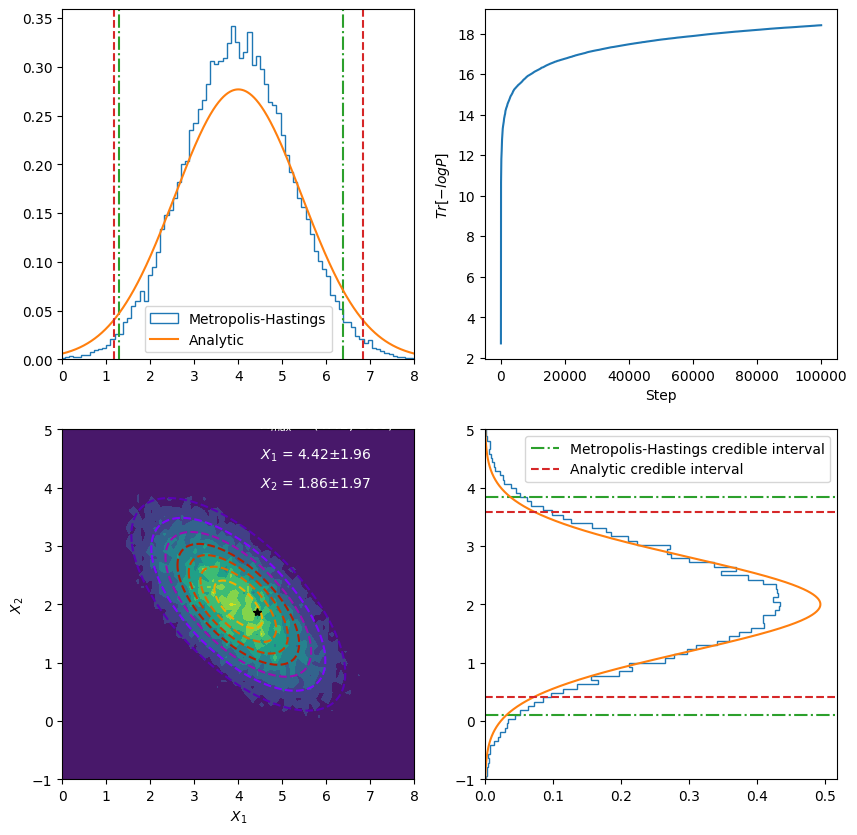

In [15]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(223)

ax.contour(x1, x2, Z, linestyles='dashed', cmap='gnuplot')
ax.contourf(X1_MH, X2_MH, histo2D_MH.T)
ax.plot(xmax_MH[0], xmax_MH[1], 'k*')
ax.text(4.5, 5, s='$X_{max}$ = ('+str(f'{xmax_MH[0]:.2f}')+', '+str(f'{xmax_MH[1]:.2f}')+')', c='white')
ax.text(4.5, 4.5, s='$X_{1}$ = '+str(f'{xmax_MH[0]:.2f}')+'$ \\pm $'+str(f'{bins1_MH[imax1+i1]-xmax_MH[0]:.2f}'), c='white')
ax.text(4.5, 4, s='$X_{2}$ = '+str(f'{xmax_MH[1]:.2f}')+'$ \\pm $'+str(f'{bins2_MH[imax2+i2]-xmax_MH[1]:.2f}'), c='white')
ax.set_xlim(0, 8)
ax.set_ylim(-1, 5)
ax.set_xlabel('$X_1$')
ax.set_ylabel('$X_2$')

ax = fig.add_subplot(221)

ax.hist(bins1_MH[:-1], bins1_MH, weights=counts1_MH, histtype='step', density=True, label='Metropolis-Hastings')
ax.axvline(bins1_MH[imax1+i1], c='C2', ls='-.')
ax.axvline(bins1_MH[imax1-i1], c='C2', ls='-.')

ax.plot(x1[:, 0], marginalized_1.pdf(x1[:, 0]), label='Analytic')
ax.axvline(mu[0]-credibility_marginalized_1[0], ls='--', c='C3')
ax.axvline(mu[0]+credibility_marginalized_1[0], ls='--', c='C3')
ax.legend(loc='best')
ax.set_xlim(0, 8)

ax = fig.add_subplot(224)

ax.hist(bins2_MH[:-1], bins2_MH, weights=counts2_MH, histtype='step', density=True, orientation="horizontal")
ax.axhline(bins2_MH[imax2+i2], c='C2', ls='-.', label='Metropolis-Hastings credible interval')
ax.axhline(bins2_MH[imax2-i2], c='C2', ls='-.')
ax.plot(marginalized_2.pdf(x2[0, :]), x2[0, :])
ax.axhline(mu[1]-credibility_marginalized_2[0], ls='--', c='C3', label='Analytic credible interval')
ax.axhline(mu[1]+credibility_marginalized_2[0], ls='--', c='C3')
ax.legend(loc='best')
ax.set_ylim(-1, 5)

ax = fig.add_subplot(222)
ax.plot(step_MH, trace_MH)
ax.set_xlabel('Step')
ax.set_ylabel('$Tr[-logP]$')

plt.show()

### Gibbs sampling

In [16]:
def Gibbs_sampling(x0, nstep):

    chain = np.zeros([nstep+1, 2])
    chain[0, :] = x0
    trace = [-np.log(gaussian(x0, mu, cov))]
    i = 0
    step = [i+1]

    while i < nstep:
        if i%2 == 0:
            chain[i+1, 0] = random.normal(mu[0] - (1/precision[0, 0])*precision[0, 1]*(chain[i, 1] - mu[1]), 1/precision[0, 0])
            chain[i+1, 1] = chain[i, 1]
        else:
            chain[i+1, 1] = random.normal(mu[1] - (1/precision[1, 1])*precision[1, 0]*(chain[i, 0] - mu[0]), 1/precision[1, 1])
            chain[i+1, 0] = chain[i, 0]

        trace.append(trace[-1] - np.log(gaussian(chain[i, :], mu, cov))/(i+1))
        i += 1
        step.append(i+1)

    return chain, trace, step

In [17]:
X10 = random.randint(2, 6)
X20 = random.randint(0, 4)
X0 = np.array([X10, X20])

chain_g, trace_g, step_g = Gibbs_sampling(X0, 100000)

In [18]:
X1_g, X2_g, histo2D_g, xmax_g = histogram_2D(chain_g[:, :])

counts1_g, bins1_g = np.histogram(chain_g[:, 0], Nbins, density='True')
counts2_g, bins2_g = np.histogram(chain_g[:, 1], Nbins, density='True')

i1, imax1 = credible_intervals_hist(counts1_g, bins1_g)
i2, imax2 = credible_intervals_hist(counts2_g, bins2_g)

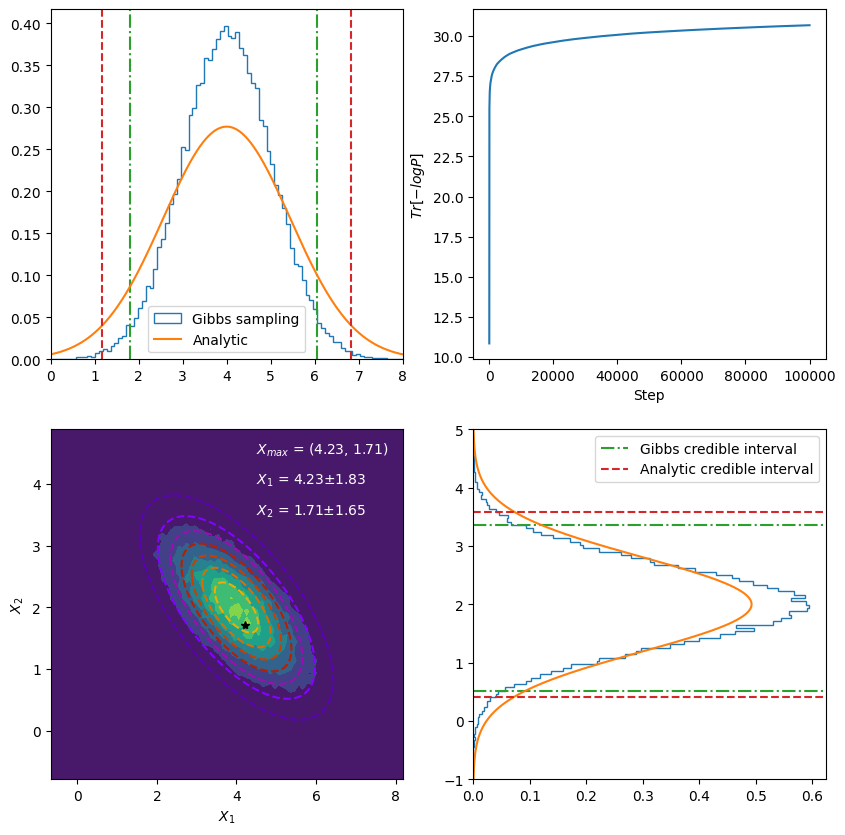

In [19]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(223)

ax.contour(x1, x2, Z, linestyles='dashed', cmap='gnuplot')
ax.contourf(X1_g, X2_g, histo2D_g.T)
ax.plot(xmax_g[0], xmax_g[1], 'k*')
ax.text(4.5, 4.5, s='$X_{max}$ = ('+str(f'{xmax_g[0]:.2f}')+', '+str(f'{xmax_g[1]:.2f}')+')', c='white')
ax.text(4.5, 4, s='$X_{1}$ = '+str(f'{xmax_g[0]:.2f}')+'$ \\pm $'+str(f'{bins1_g[imax1+i1]-xmax_g[0]:.2f}'), c='white')
ax.text(4.5, 3.5, s='$X_{2}$ = '+str(f'{xmax_g[1]:.2f}')+'$ \\pm $'+str(f'{bins2_g[imax2+i2]-xmax_g[1]:.2f}'), c='white')
ax.set_xlim(0, 8)
ax.set_ylim(-1, 5)
ax.set_xlabel('$X_1$')
ax.set_ylabel('$X_2$')
ax.set_xlim(X1_g[0], X1_g[-1])
ax.set_ylim(X2_g[0], X2_g[-1])

ax = fig.add_subplot(221)

ax.hist(bins1_g[:-1], bins1_g, weights=counts1_g, histtype='step', density=True, label='Gibbs sampling')
ax.axvline(bins1_g[imax1+i1], c='C2', ls='-.')
ax.axvline(bins1_g[imax1-i1], c='C2', ls='-.')
ax.plot(x1[:, 0], marginalized_1.pdf(x1[:, 0]), label='Analytic')
ax.axvline(mu[0]-credibility_marginalized_1[0], ls='--', c='C3')
ax.axvline(mu[0]+credibility_marginalized_1[0], ls='--', c='C3')
ax.legend(loc='best')
ax.set_xlim(0, 8)

ax = fig.add_subplot(224)

ax.hist(bins2_g[:-1], bins2_g, weights=counts2_g, histtype='step', density=True, orientation="horizontal")
ax.axhline(bins2_g[imax2+i2], c='C2', ls='-.', label='Gibbs credible interval')
ax.axhline(bins2_g[imax2-i2], c='C2', ls='-.')
ax.plot(marginalized_2.pdf(x2[0, :]), x2[0, :])
ax.axhline(mu[1]-credibility_marginalized_2[0], ls='--', c='C3', label='Analytic credible interval')
ax.axhline(mu[1]+credibility_marginalized_2[0], ls='--', c='C3')
ax.legend(loc='best')
ax.set_ylim(-1, 5)

ax = fig.add_subplot(222)

ax.plot(step_g, trace_g)
ax.set_xlabel('Step')
ax.set_ylabel('$Tr[-logP]$')

plt.show()